## Sound recornition with MFCC and CNN

In [2]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.io import wavfile
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import IPython.display as ipd

from python_speech_features import mfcc

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.callbacks import ModelCheckpoint

import librosa
import librosa.display

from configparser import ConfigParser

Using TensorFlow backend.


### Configuration
Parameters for MFCC calculation and paths for saving model

In [3]:
sound = "Finger_snapping"
nfilt = 26
nfeat = 13
nfft = 1103
rate = 44100
step = int(rate/10)
train_folder = "train"
test_folder = "test"
train_description = "train.csv"
test_description = "test.csv"
global_min, global_max = float('inf'), -float('inf')
model_path = os.path.join("models", sound + '.model')
settings_path = os.path.join('pickles', sound + '.p')

config = ConfigParser()
config.read("config.ini")
config.set("main", "sound", sound)
config.set("main", "nfilt", str(nfilt))
config.set("main", "nfeat", str(nfeat))
config.set("main", "nfft", str(nfft))
config.set("main", "rate", str(rate))
config.set("main", "step", str(step))
config.set("main", "train_folder", train_folder)
config.set("main", "test_folder", test_folder)
config.set("main", "train_description", train_description)
config.set("main", "test_description", test_description)
config.set("main", "model_path ", model_path)

### Functions

In [4]:
def plot_samples(df_chosen, folder, class_num, num_samples, title):

    fig, axes = plt.subplots(nrows=2, ncols=num_samples, sharex=False, 
                         sharey=False, figsize=(20,5))
    fig.suptitle(title, size = 16)

    for x in range(2):
        for y in range(num_samples):
            wav_file = df_chosen[df_chosen.label == class_num].iloc[y,0]
            signal, rate = librosa.load(folder + "/" + wav_file, sr=44100)
            mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T

            axes[x,y].set_title(wav_file)
            if(x == 0):
                axes[x,y].plot(list(signal))
            if(x == 1):
                axes[x,y].imshow(list(mel),
                        cmap='hot', interpolation='nearest')

    plt.show()

In [5]:
def play_sound(folder, file, title):
    print(title)
    wav, rate = librosa.load(folder + "/" + file)
    ipd.display(ipd.Audio(wav, rate=rate))

In [6]:
def find_contiguous_colors(colors):
    segs = []
    curr_seg = []
    prev_color = ''
    for c in colors:
        if c == prev_color or prev_color == '':
            curr_seg.append(c)
        else:
            segs.append(curr_seg)
            curr_seg = []
            curr_seg.append(c)
        prev_color = c
    segs.append(curr_seg)
    return segs
 
def plot_multicolored_lines(x,y,colors):
    segments = find_contiguous_colors(colors)
    plt.figure()
    start= 0
    for seg in segments:
        end = start + len(seg)
        l, = plt.gca().plot(x[start:end],y[start:end],lw=2,c=seg[0]) 
        start = end


def plot_prediction_matches(signal, match_plot, fn_prob):
    x = np.arange(len(signal))
    
    match_plot_final = []
    for k in range(len(match_plot)):
        i = match_plot[k]
        for j in range(step):
            match_plot_final.append(i)
    
    match_plot_final_c = []
    for p in match_plot_final:
        if(p == 1) and (fn_prob[0][1] >= fn_prob[0][0]):
            match_plot_final_c.append("green")
        elif(p == 1) and (fn_prob[0][1] < fn_prob[0][0]):
            match_plot_final_c.append("red")
        elif(p == 0):
            match_plot_final_c.append("blue")

    plot_multicolored_lines(x,list(signal),match_plot_final_c)
    labels = [str(item/rate) for item in plt.get_xticklabels()]
    plt.set_xticklabels(labels)
    plt.show()

### Loading data
Can be found here: https://zenodo.org/record/2552860#.XMaeU99fiV6

In [7]:
def load_files(description_file): 
    df = pd.read_csv(description_file)
    df_true = df[df.label == sound]
    df_true_len = len(df_true)

    df_chosen = df_true.append(df[df.label != sound][:df_true_len])
    df_chosen = df_chosen[['fname', 'label']]

    print("\nTrue class count: " + str(df_true_len))
    print("Merged count: " + str(len(df_chosen)) + "\n")

    df_chosen.loc[df_chosen.label != sound, 'label'] = 0
    df_chosen.loc[df_chosen.label == sound, 'label'] = 1
    df_chosen[df_true_len-3:df_true_len+3]
    
    return df_chosen



True class count: 117
Merged count: 234

Finger_snapping sample


Other classes sample


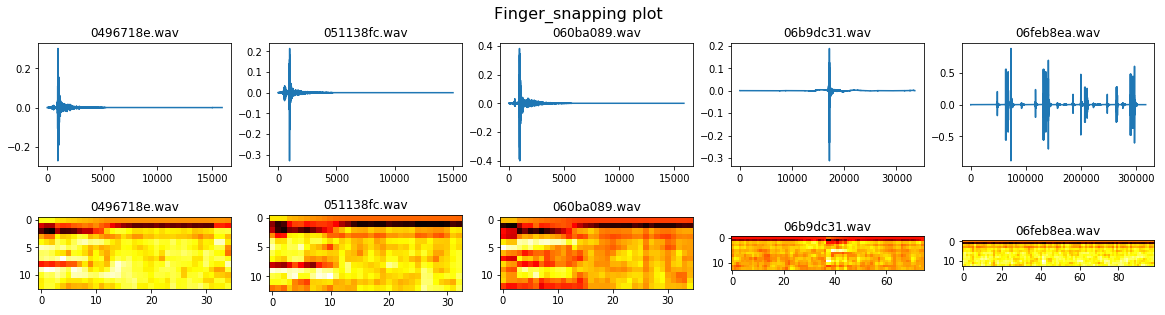

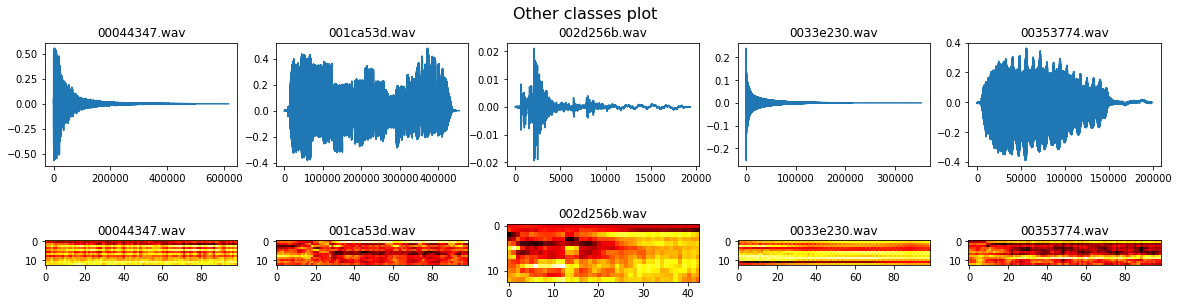

In [48]:
df_chosen = load_files(train_description)

play_sound(train_folder, df_chosen["fname"].iloc[0], sound + " sample")
play_sound(train_folder, df_chosen["fname"].iloc[-1], "Other classes sample")

plot_samples(df_chosen, train_folder, 1, 5, sound + " plot")
plot_samples(df_chosen, train_folder, 0, 5, "Other classes plot")

### Building MFCC features 
As shown on the previous plot, MFCC features have a significant difference for different sounds, and can be considered more suitable for training a model, that FFT transform.

MFCC features are calculated for a number of samples, taken from the original files (size of sample = 4410 for 44100 rate). 
Samples are taken randomly and each sample is associated with a particular class. That procedure forms training set.

In [49]:
def mfcc_features(n_samples, folder):

    X = []
    y = []
    
    _min, _max = float('inf'), -float('inf')
    
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p=prob_dist)
        file = np.random.choice(df_chosen[df_chosen.label==rand_class].index)
        rate, wav = wavfile.read(folder + "/" + file)
        label = df_chosen.at[file, 'label']
        rand_index = np.random.randint(0, wav.shape[0]-step)
        sample = wav[rand_index: rand_index+step]
        X_sample = mfcc(sample, rate, numcep=nfeat, nfilt=nfilt, nfft=nfft).T
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        
        global_min = _min
        global_max = _max
        
        X.append(X_sample)
        y.append(classes.index(label))
        
    X, y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)
    print(X.shape)
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    y = to_categorical(y, num_classes=2)

    config.set("main", "global_min", str(global_min))
    config.set("main", "global_max", str(global_max))
 
    with open('config.ini', 'w') as f:
        config.write(f)

    return X, y, global_min, global_max 

In [50]:
df_chosen.set_index('fname', inplace=True)

for f in df_chosen.index:
    rate, signal = wavfile.read(train_folder + "/" + f)
    df_chosen.at[f, 'length'] = signal.shape[0] / rate
   
classes = list(np.unique(df_chosen.label))
class_dist = df_chosen.groupby(['label'])['length'].mean()

n_samples = 2 * int(df_chosen['length'].sum() / 0.1)
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

X, y, g_min, g_max = mfcc_features(n_samples, train_folder)
global_min = g_min
global_max = g_max

print(X.shape)

100%|██████████| 24342/24342 [01:13<00:00, 329.73it/s]


(24342, 13, 9)
(24342, 13, 9, 1)


### CNN model creation
Predicions are made using simple CNN model, based on https://github.com/seth814/Instrument-Classifier

In [23]:
def CNN():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1),
                    padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1),
                    padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1),
                padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', strides=(1, 1),
            padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.summary()

    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['acc'])
    
    return model

In [24]:
input_shape = (X.shape[1], X.shape[2], 1)
print(input_shape)
model = CNN()

(13, 9, 1)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 13, 9, 16)         160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 9, 32)         4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 9, 64)         18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 9, 128)        73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 4, 128)         0         
_________________________________________________________________
dropout_1 

In [25]:
checkpoint = ModelCheckpoint(model_path, monitor='val_acc', 
                             verbose=1, mode='max', save_best_only=True, 
                             save_weights_only=False, period=1)
model.fit(X, y, epochs=10, batch_size=32, shuffle=True, 
          validation_split=0.1, callbacks=[checkpoint])
model.save(model_path)

Instructions for updating:
Use tf.cast instead.
Train on 21907 samples, validate on 2435 samples
Epoch 1/10
21907/21907 [==============================] - 24s 1ms/step - loss: 0.3374 - acc: 0.8409 - val_loss: 0.2643 - val_acc: 0.8850

Epoch 00001: val_acc improved from -inf to 0.88501, saving model to models/Finger_snapping.model
Epoch 2/10
21907/21907 [==============================] - 24s 1ms/step - loss: 0.2515 - acc: 0.8881 - val_loss: 0.2296 - val_acc: 0.8986

Epoch 00002: val_acc improved from 0.88501 to 0.89856, saving model to models/Finger_snapping.model
Epoch 3/10
21907/21907 [==============================] - 24s 1ms/step - loss: 0.2186 - acc: 0.9054 - val_loss: 0.1958 - val_acc: 0.9179

Epoch 00003: val_acc improved from 0.89856 to 0.91786, saving model to models/Finger_snapping.model
Epoch 4/10
21907/21907 [==============================] - 24s 1ms/step - loss: 0.1942 - acc: 0.9175 - val_loss: 0.1866 - val_acc: 0.9179

Epoch 00004: val_acc did not improve from 0.91786
Epoc

### Testing predictions
For prediction it's also needed to split a file into samples of size 4410, and then make a prediction for each sample.
Next step is to make a class assumption for the whole file, averaging predicitons for samples.
match_plot is than needed for creating a graph of possible pattern matches. 

In [26]:
def single_prediction(folder, filename):
    
    fn_prob = []
    match_plot = []
    y_prob = []
    y_pred = []
    
    rate, wav = wavfile.read(os.path.join(folder, filename))
    
    for i in range(0, wav.shape[0]-step, step):
        sample = wav[i:i+step]
        x = mfcc(sample, rate, numcep=nfeat, 
                 nfilt=nfilt, nfft=nfft).T

        x = (x - global_min) / (global_max - global_min)

        x = x.reshape(1, x.shape[0], x.shape[1], 1)
        y_hat = model.predict(x)
        
        if(y_hat[0][1] > y_hat[0][0]):
            match_plot.append(1)
        else:
            match_plot.append(0)
            
        y_prob.append(y_hat)
    
    fn_prob.append(np.mean(y_prob, axis=0).flatten())
    
    if(fn_prob[0][1] >= fn_prob[0][0]):
        y_pred.append(1)
    else:
        y_pred.append(0)
    
    return fn_prob, y_pred, match_plot, wav

Calculating prediction for every file in test folder

In [33]:
df_test = load_files(test_description)
df_test.set_index('fname', inplace=True)
    
files_prob = []
files_pred = []
files = []

for fn in tqdm(df_test.index):
    fn_prob, file_pred, match_plot, wav = single_prediction(test_folder, fn)
    files.append(fn)
    files_prob.append(fn_prob[0])
    files_pred.append(file_pred)
            
df_test.reset_index(inplace=True)
print(files[0] + ": ")
print(sound + " prob: " + str(files_prob[0][1]))
print("Other prob: " + str(files_prob[0][0]))
print("\n")

  2%|▏         | 1/66 [00:00<00:07,  8.61it/s]


True class count: 33
Merged count: 66



100%|██████████| 66/66 [00:10<00:00,  6.12it/s]

17e829a7.wav: 
Finger_snapping prob: 0.98322153
Other prob: 0.016778337




### Accuracy measurment
ROC curve is used for accuracy measurment. 

In [34]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(df_test["label"].tolist(), files_pred)

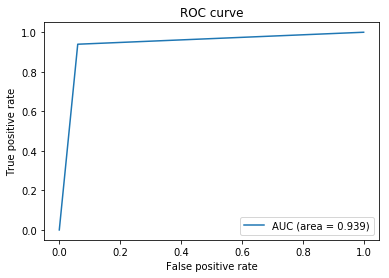

In [35]:
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot(fpr_keras, tpr_keras, label='AUC (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Test prediction

Finger_snapping similarity: 0.98322153


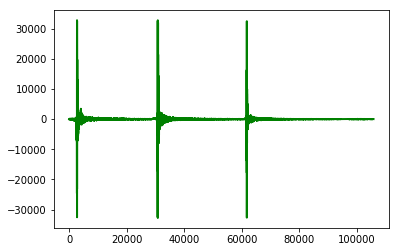

In [30]:
fn_prob, y_pred, match_plot, wav = single_prediction("test", "snap1.wav")
print(sound + " similarity: " + str(fn_prob[0][1])) 
plot_prediction_matches(wav, match_plot, fn_prob)